# TensorFlow roBERTa - Unsupervised Text Selection
Wow, this notebook does not use `selected_text`. This notebook only uses the columns `text` and `sentiment`. We train a roBERTa model to predict sentiment (pos, neg, neu) from Tweet `text` achieving 80% accuracy. We then display what part of the text was influencial in deciding whether the text was postive, negative, or neutral. This is **unsupervised** learning because we are learning the `selected_text` without using the `selected_text`.

This unsupervised DL notebook is inspired by Nick's awesome unsupervised ML notebook [here][1] and it's similar to my previous unsupervised DL notebook for image recognition [here][2]

[1]: https://www.kaggle.com/nkoprowicz/a-simple-solution-using-only-word-counts
[2]: https://www.kaggle.com/cdeotte/unsupervised-masks-cv-0-60

# Load Data

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from transformers import *
import tokenizers
from IPython.core.display import display, HTML
print('TensorFlow',tf.__version__)

TensorFlow 2.1.0


In [2]:
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# roBERTa Tokenization
In this section, we create a variety of roBERTa inputs and targets. In this notebook, we only need tokenized `text` and target `sentiment` (`tar4`). However, for your assistance with future models, we also make roBERTa inputs for a question and answer supervised model (use `DO_QUES_ANS = True`) with accompanying start token (`tar1`) and end token (`tar2`) targets. Feel free to use this for a TensorFlow QA solution for this competition.

Below tokenization code logic is inspired by Abhishek's PyTorch notebook [here][1]

[1]: https://www.kaggle.com/abhishek/roberta-inference-5-folds

In [3]:
# Define the maximum length for tokenized sequences
MAX_LEN = 96

# Path to the directory containing the tokenizer files
PATH = '../input/tf-roberta/'

# Initialize the ByteLevelBPETokenizer with the specified vocabulary and merges files
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json',  # Path to the vocabulary file
    merges_file=PATH+'merges-roberta-base.txt',  # Path to the merges file
    lowercase=True,  # Convert all text to lowercase
    add_prefix_space=True  # Add a space before each word (useful for tokenizing)
)

# Dictionary mapping sentiment labels to their corresponding IDs
sentiment_id = {
    'positive': 1313,  # ID for positive sentiment
    'negative': 2430,  # ID for negative sentiment
    'neutral': 7974    # ID for neutral sentiment
}

# Dictionary mapping sentiment labels to target values
sentiment_tar = {
    'positive': 1,  # Target value for positive sentiment
    'negative': 2,  # Target value for negative sentiment
    'neutral': 0    # Target value for neutral sentiment
}

# Boolean flag to indicate whether to perform question-answering
DO_QUES_ANS = False


In [4]:
# Get the number of training samples
ct = train.shape[0]

# Initialize arrays for RoBERTa inputs and targets
ids = np.ones((ct, MAX_LEN), dtype='int32')  # Token IDs
att = np.zeros((ct, MAX_LEN), dtype='int32')  # Attention masks
tok = np.zeros((ct, MAX_LEN), dtype='int32')  # Token type IDs (not used here)

# Initialize arrays for question-answer targets
tar1 = np.zeros((ct, MAX_LEN), dtype='int32')  # Start positions
tar2 = np.zeros((ct, MAX_LEN), dtype='int32')  # End positions

# Initialize arrays for segmentation targets
tar3 = np.zeros((ct, MAX_LEN), dtype='int32')  # Segmentation masks

# Initialize array for sentiment targets
tar4 = np.zeros((ct), dtype='int32')  # Sentiment labels

# Initialize array for character centers
cha = np.zeros((ct, MAX_LEN), dtype='float32')  # Character center positions

# Loop through each training sample
for k in range(train.shape[0]):
    
    # Find the overlap between text and selected text
    text1 = " " + " ".join(train.loc[k, 'text'].split())
    text2 = " ".join(train.loc[k, 'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)] = 1
    if text1[idx-1] == ' ': 
        chars[idx-1] = 1
    
    # Encode the text using the tokenizer
    enc = tokenizer.encode(text1)
    
    # Find offsets and character centers
    off = []
    ii = 0
    ct = 0
    for i, t in enumerate(enc.ids):
        w = tokenizer.decode([t])
        off.append((ii, ii+len(w)))
        ii += len(w)
        cha[k, i] = ct + len(w) / 2.
        ct += len(w)
    
    # Find the tokens corresponding to the selected text
    tks = []
    for i, (a, b) in enumerate(off):
        sm = np.sum(chars[a:b])
        if sm > 0: 
            tks.append(i)
    
    # Create RoBERTa inputs
    stok = sentiment_id[train.loc[k, 'sentiment']]
    ids[k, :len(enc.ids)+2] = [0] + enc.ids + [2]
    att[k, :len(enc.ids)+2] = 1
    if DO_QUES_ANS:  # Use this for question-answering
        ids[k, len(enc.ids)+2:len(enc.ids)+5] = [2] + [stok] + [2]
        att[k, len(enc.ids)+2:len(enc.ids)+5] = 1
    
    # Create RoBERTa targets
    if len(tks) > 0:
        tar1[k, tks[0]+1] = 1  # Start position
        tar2[k, tks[-1]+1] = 1  # End position
    for j in range(len(tks)):
        tar3[k, tks[j]+1] = 1  # Segmentation mask
    tar4[k] = sentiment_tar[train.loc[k, 'sentiment']]  # Sentiment label


# roBERTa Model
We use pretrained roBERTa base model and add a classification head.

In [5]:
def build_model():
    # Define input layers for token IDs, token type IDs, and attention masks
    q_id = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)  # Input for token IDs
    q_type = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)  # Input for token type IDs
    q_mask = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)  # Input for attention masks
    
    # Load the RoBERTa configuration and pre-trained model
    config = RobertaConfig.from_pretrained(PATH + 'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH + 'pretrained-roberta-base.h5', config=config)
    
    # Get the output from the RoBERTa model
    x = bert_model(q_id, attention_mask=q_mask, token_type_ids=q_type)
    
    # Apply dropout to the output
    x1 = tf.keras.layers.Dropout(0.2)(x[0])
    
    # Apply global average pooling to the output
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    
    # Add a dense layer with softmax activation for classification
    x1 = tf.keras.layers.Dense(3, activation='softmax')(x1)
    
    # Define the model with the specified inputs and outputs
    model = tf.keras.models.Model(inputs=[q_id, q_mask, q_type], outputs=x1)
    
    # Compile the model with Adam optimizer and sparse categorical cross-entropy loss
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy, 
        optimizer=optimizer, 
        metrics=['accuracy']
    )
    
    return model


# Train Model
We train on 80% train.csv and validate on 20% train.csv. Our model achieves 80% validation accuracy predicting `sentiment` from Tweet `text`.

In [6]:
# Create a simple validation set

# Indices for the training set (80% of the data)
idxT = np.arange(0, 4 * train.shape[0] // 5)

# Indices for the validation set (remaining 20% of the data)
idxV = np.arange(4 * train.shape[0] // 5, train.shape[0])


In [7]:
# Build the model
model = build_model()

# Define a callback to save the model's weights
sv = tf.keras.callbacks.ModelCheckpoint(
    'cam.h5',  # Filepath to save the model
    monitor='val_loss',  # Monitor the validation loss
    verbose=1,  # Verbosity mode
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the model weights
    mode='auto',  # Mode for monitoring
    save_freq='epoch'  # Save the model after every epoch
)

# Train the model
model.fit(
    [ids[idxT,], att[idxT,], tok[idxT,]],  # Training data (inputs)
    tar4[idxT],  # Training data (targets)
    validation_data=([ids[idxV,], att[idxV,], tok[idxV,]], tar4[idxV]),  # Validation data
    epochs=2,  # Number of epochs to train
    batch_size=32,  # Batch size
    verbose=1,  # Verbosity mode
    callbacks=[sv]  # List of callbacks
)

# Load the best model weights
model.load_weights('cam.h5')


Train on 21984 samples, validate on 5497 samples
Epoch 1/2
21952/21984 [============================>.] - ETA: 0s - loss: 0.5958 - accuracy: 0.7477
Epoch 00001: val_loss improved from inf to 0.50613, saving model to cam.h5
21984/21984 [==============================] - 280s 13ms/sample - loss: 0.5960 - accuracy: 0.7477 - val_loss: 0.5061 - val_accuracy: 0.7910
Epoch 2/2
21952/21984 [============================>.] - ETA: 0s - loss: 0.4605 - accuracy: 0.8148
Epoch 00002: val_loss did not improve from 0.50613
21984/21984 [==============================] - 266s 12ms/sample - loss: 0.4605 - accuracy: 0.8148 - val_loss: 0.5091 - val_accuracy: 0.7866


# CAM Extraction Model
An example of CAM extraction for image recognition is [here][1]. The basic idea is as follows. When our model classifies a text, it will activate one of three classification outputs (pos, neg, neu). We trace that output backwards to see which words contributed the most to the decision.

[1]: https://www.kaggle.com/cdeotte/unsupervised-masks-cv-0-60

In [8]:
# Create a new model from the existing model to extract activation maps

# Get the weights of the last layer of the original model
all_layer_weights = model.layers[-1].get_weights()[0]

# Define a new model that outputs the activation maps and the final output
cam_model = tf.keras.Model(
    inputs=model.input,  # Input layers of the original model
    outputs=(model.layers[-4].output, model.layers[-1].output)  # Outputs from the 4th last layer and the last layer
)

# Dictionary to map prediction indices to sentiment labels
pr = {0: 'NEUTRAL', 1: 'POSITIVE', 2: 'NEGATIVE'}


# Display Influential Subtext
The code to highlight the text with different colors is from notebook [here][1]. The plot above each sentence indicates the strength of influence of the words below. The x axis is the sentence and the y axis is the strenth of influence in determining the sentiment prediction.

[1]: https://www.kaggle.com/jeinsong/html-text-segment-visualization

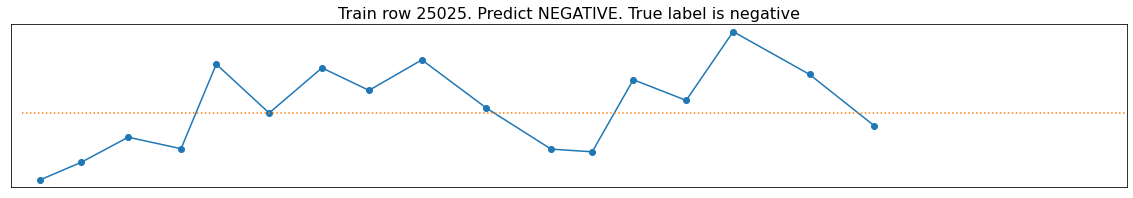

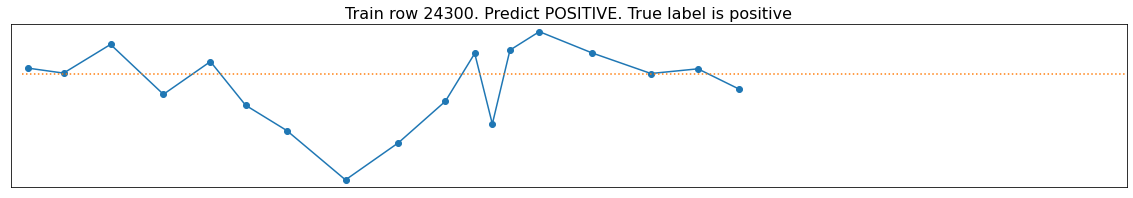

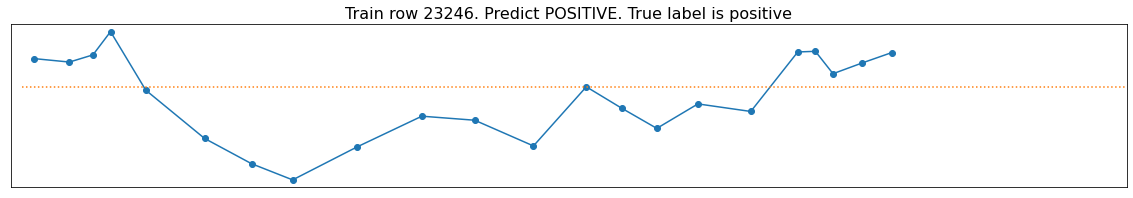

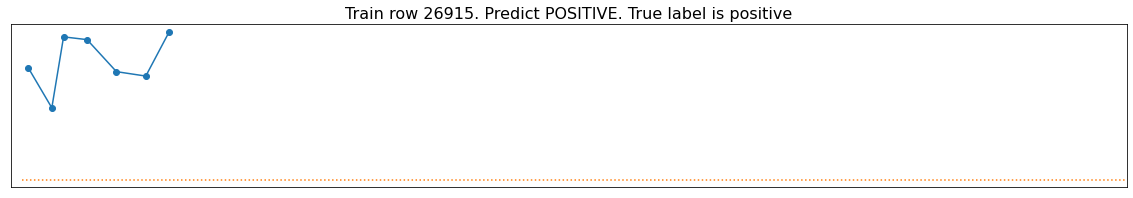

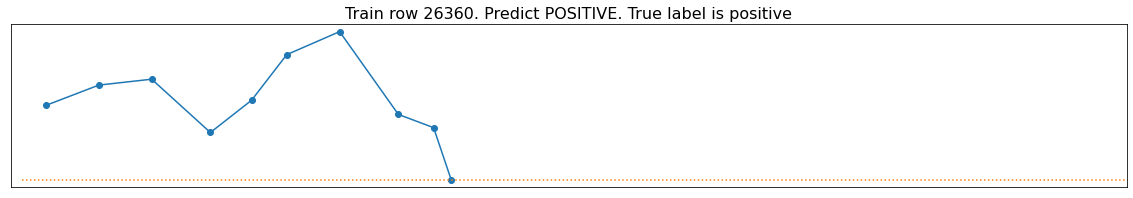

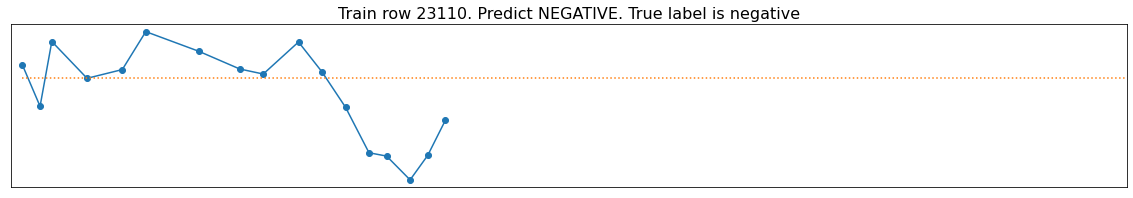

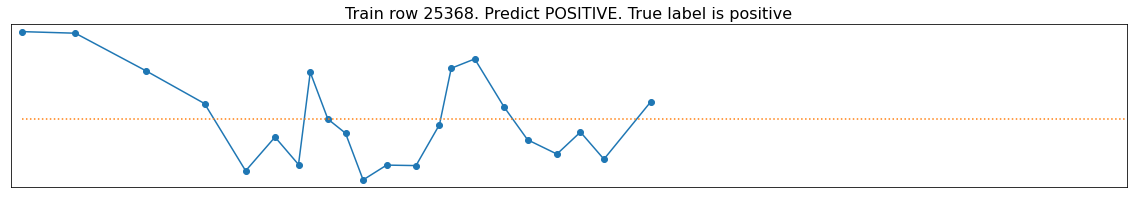

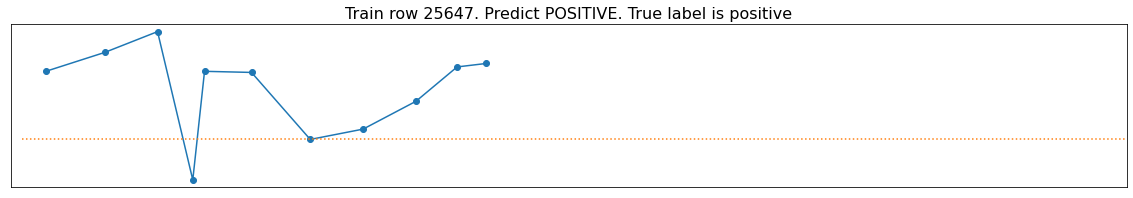

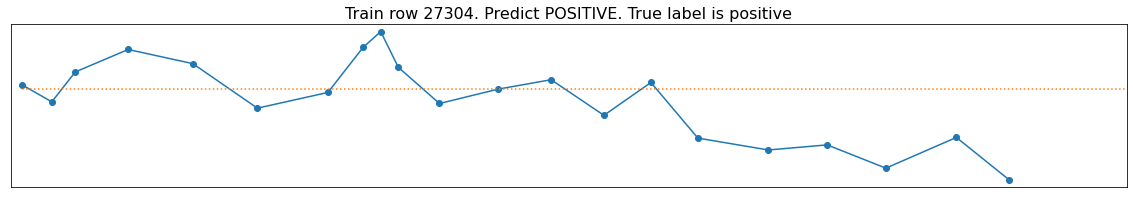

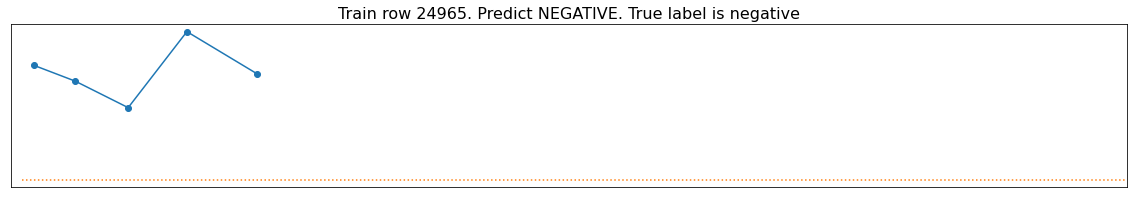

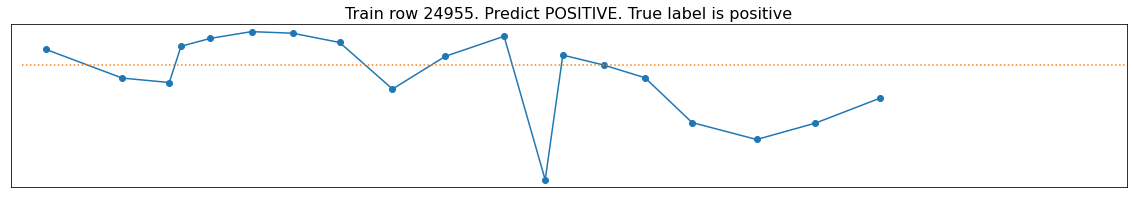

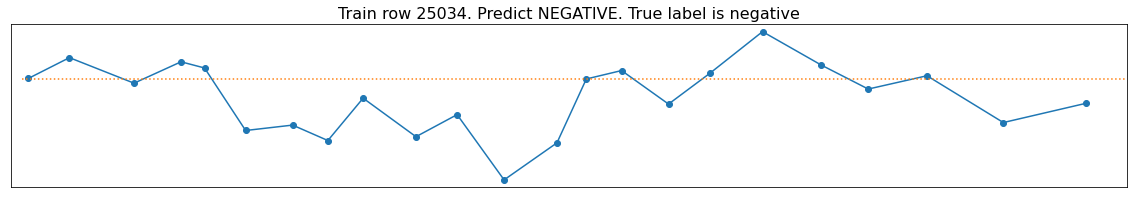

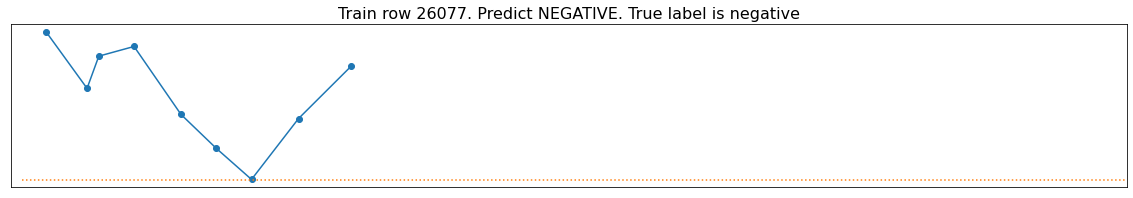

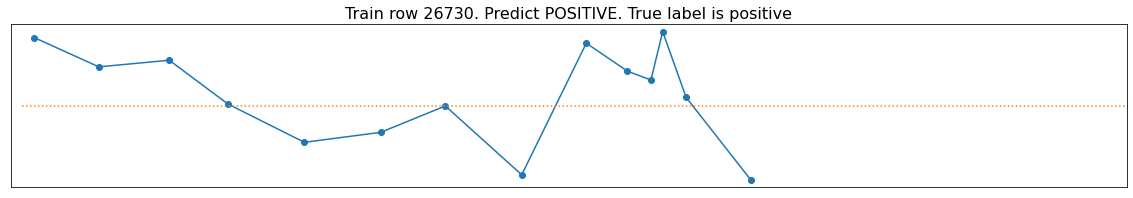

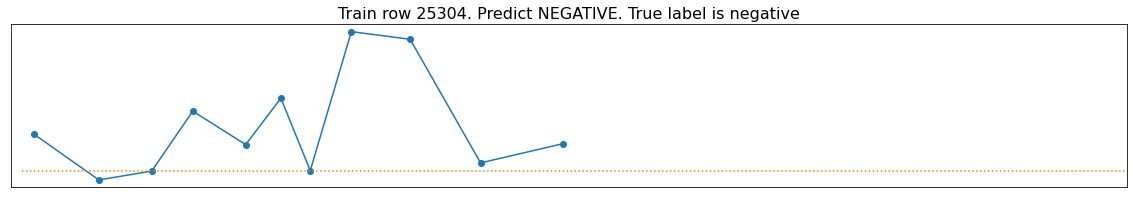

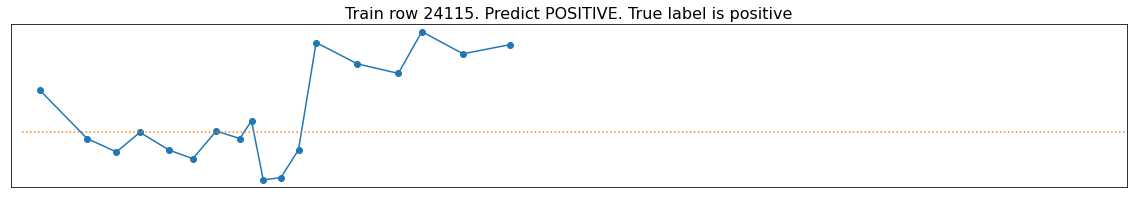

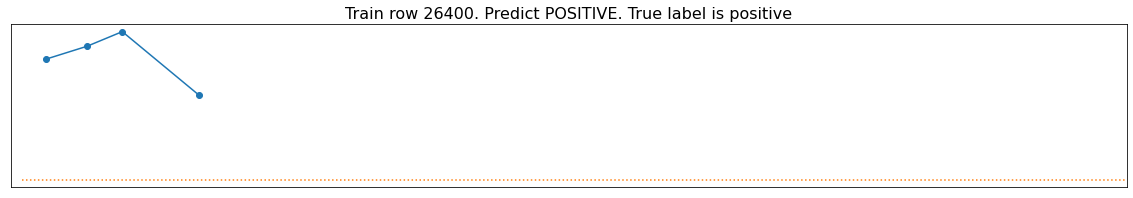

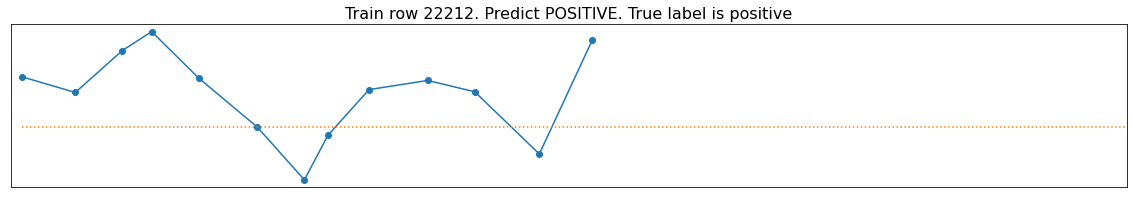

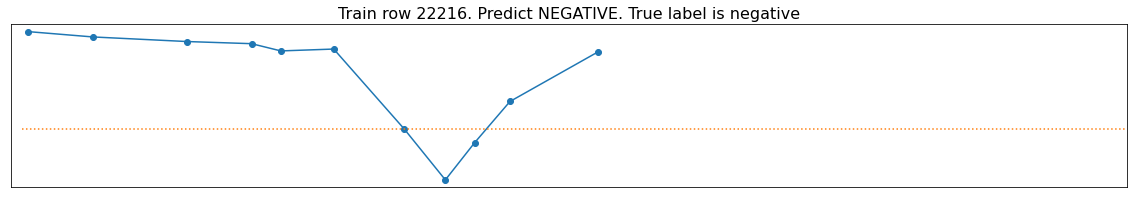

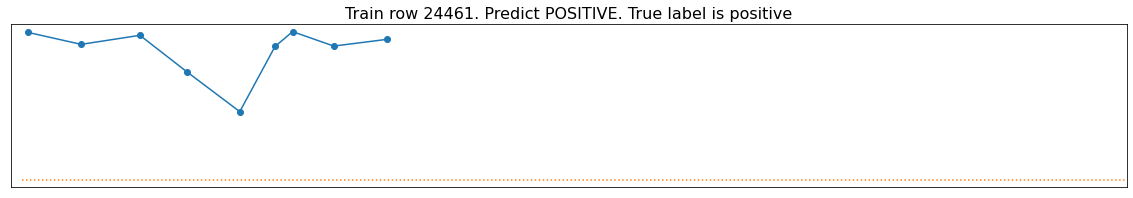

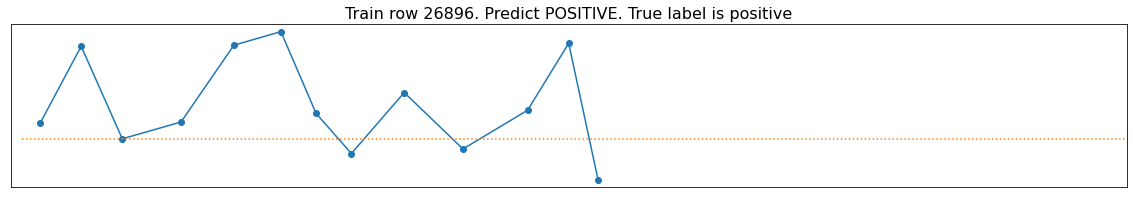

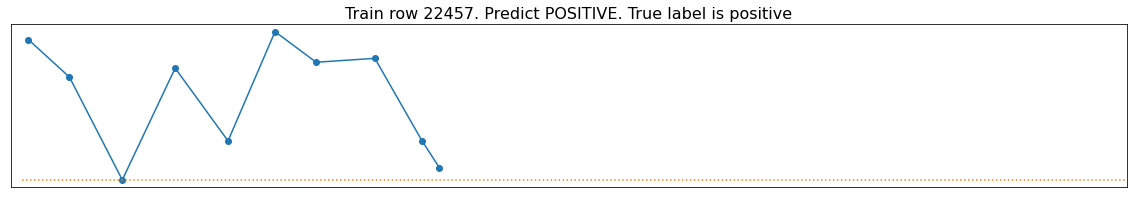

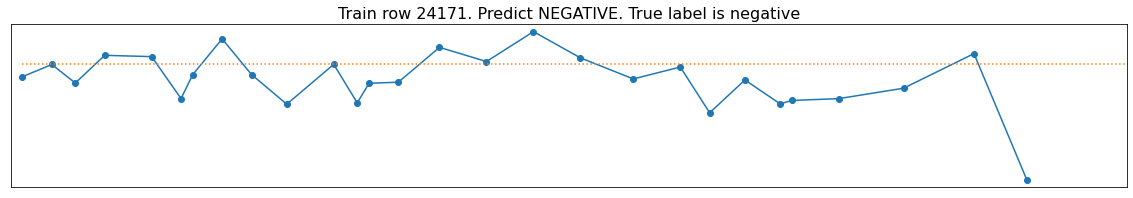

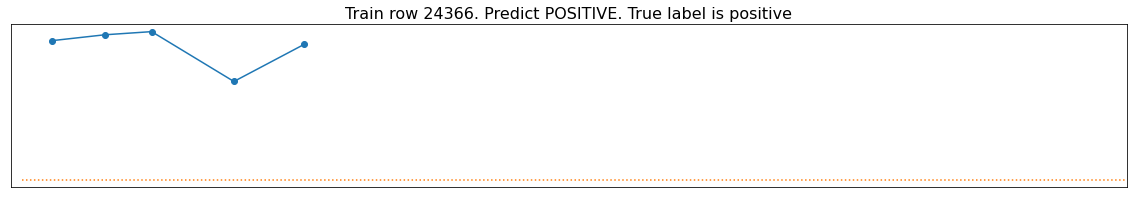

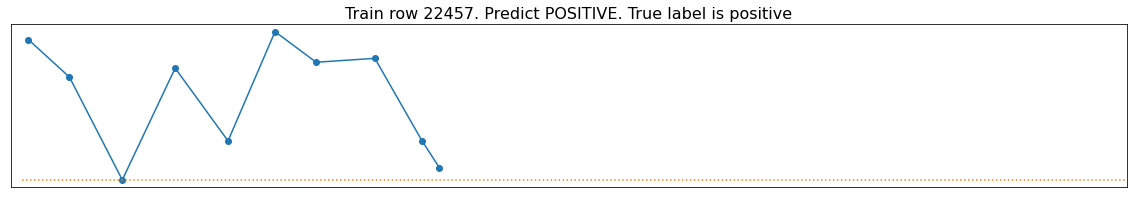

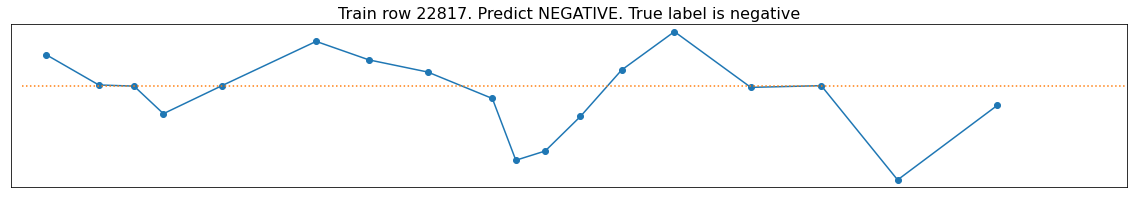

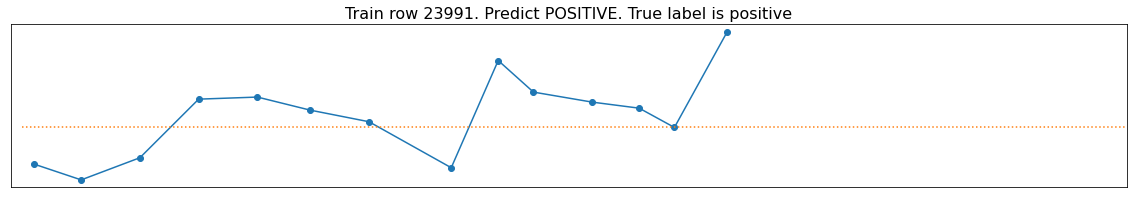

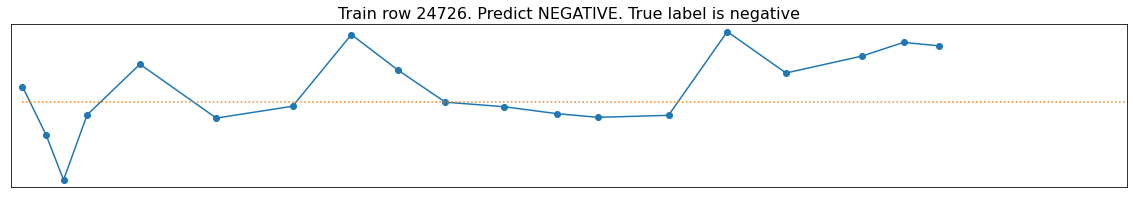

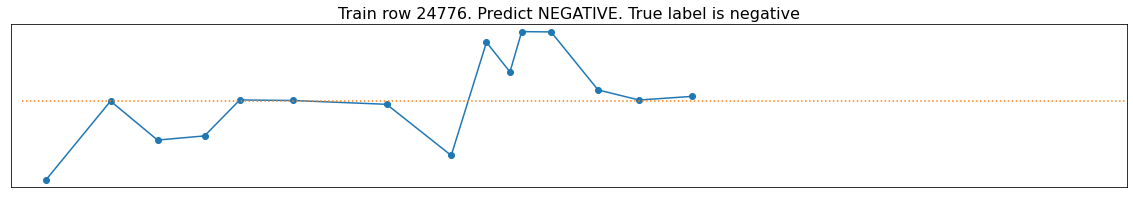

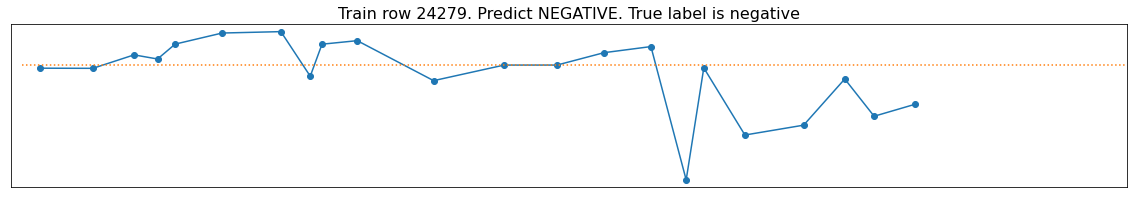

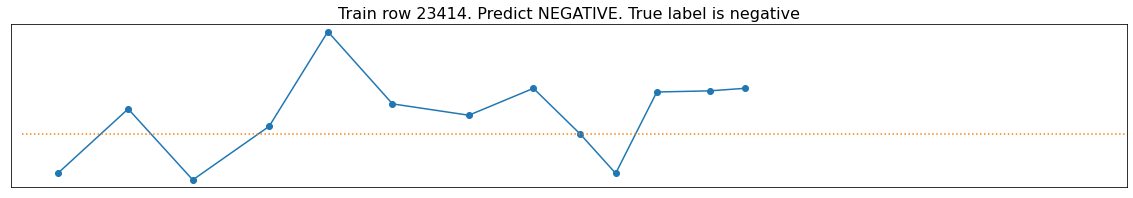

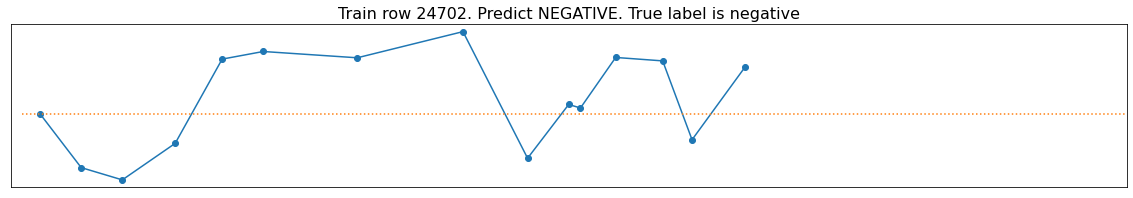

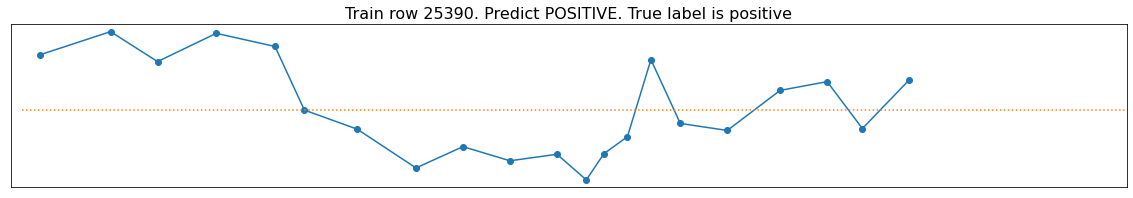

In [9]:
# Loop through 100 random samples from the validation set
for kk in range(100):
    # Randomly select an index from the validation set
    k = np.random.choice(np.arange(4 * train.shape[0] // 5, train.shape[0]))
    
    # Skip samples with neutral sentiment or text length greater than 95 characters
    if train.loc[k, 'sentiment'] == 'neutral': 
        continue  # Skip neutral sentiment (considered boring)
    if len(train.loc[k, 'text']) > 95: 
        continue  # Skip if text is too long for display
    
    # Extract influential text using the CAM model
    last_conv_output, _, pred_vec = cam_model.predict([ids[k:k+1, :], att[k:k+1, :], tok[k:k+1, :]])
    last_conv_output = np.squeeze(last_conv_output)
    pred = np.argmax(pred_vec)
    layer_weights = all_layer_weights[:, pred]
    final_output = np.dot(last_conv_output, layer_weights)
    
    # Skip misclassified samples
    if pr[pred] != train.loc[k, 'sentiment'].upper(): 
        continue
    
    # Plot influence values
    print()
    plt.figure(figsize=(20, 3))
    idx = np.sum(att[k, :])
    v = np.argsort(final_output[:idx-1])
    mx = final_output[v[-1]]
    x = max(-10, -len(v))
    mn = final_output[v[x]]
    plt.plot(cha[k, :idx-2], final_output[1:idx-1], 'o-')
    plt.plot([1, 95], [mn, mn], ':')
    plt.xlim((0, 95))
    plt.yticks([]); plt.xticks([])
    plt.title('Train row %i. Predict %s. True label is %s' % (k, pr[pred], train.loc[k, 'sentiment']), size=16)
    plt.show()
    
    # Display activation text
    html = ''
    for j in range(1, idx):
        x = (final_output[j] - mn) / (mx - mn)
        html += "<span style='background:{};font-family:monospace'>".format('rgba(255,255,0,%f)' % x)
        html += tokenizer.decode([ids[k, j]])
        html += "</span>"
    html += " (predict)"
    display(HTML(html))

    # Display true selected text
    text1 = " ".join(train.loc[k, 'text'].lower().split())
    text2 = " ".join(train.loc[k, 'selected_text'].lower().split())
    sp = text1.split(text2)
    html = "<span style='font-family:monospace'>" + sp[0] + "</span>"
    for j in range(1, len(sp)):
        html += "<span style='background:yellow;font-family:monospace'>" + text2 + '</span>'
        html += "<span style='font-family:monospace'>" + sp[j] + "</span>"
    html += " (true)"
    display(HTML(html))
    print()
